In [1]:
import healpy
from jax_healpy import pixelfunc as jhp
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
import optax
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
jax.config.update("jax_enable_x64", True)

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [125]:
b = 7.5
v_inf = 2
gm = 40
rp = 2.5
vmax = 6
vr = 3.33
v0 = np.sqrt(gm/rp)

.5*(1 + .5) * (b*v_inf/rp)**2
((2*vmax + v0)/3)**2 * (3/4)
256 / 4
40 / 2.5
# 64*4
vf = 16 / 3
term = (rp * vf**2) / gm
e = np.sqrt(1 + (term)**2 - 2 * (term))
a = rp / (1-e)
ra = a * (1+e)
a, ra

(11.249999999999984, 19.999999999999968)

In [2]:
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = jnp.cos(ang); s = jnp.sin(ang); C = 1-c
    # vec = vec/jnp.linalg.norm(vec, axis=-1, keepdims=True) # just added
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=jnp.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

# def xyz2thphi(xyz):
#     """Convert xyz vectors (x,y,z along first axis) into angles theta
#     (from z axis), phi (counter-clockwise around z, 0 at x axis)."""
#     x,y,z = xyz
#     phi = jnp.arctan2(y, x)
#     th = jnp.arctan2(jnp.sqrt(x**2+y**2),z)
#     return jnp.array([th,phi], dtype=jnp.double)



def xyz2thphi(xyz, *, dtype=jnp.float64, return_mask=False, masked_fill=0.0):
    """
    Convert xyz vectors (x,y,z along first axis) into angles:
      theta (from +z), phi (counter-clockwise around +z, 0 at +x).

    - Accepts regular arrays or np.ma.MaskedArray.
    - If masked input is given (mask taken from x), masked elements are
      treated as `masked_fill` during the computation (default 0.0),
      which matches the original `.filled(0)` behavior.
    - Returns a JAX array shaped (2, ...): [theta, phi].
    - If `return_mask=True`, also returns a boolean mask shaped (2, ...),
      equal to [x.mask, x.mask] when a mask exists, else all False.
    """
    x, y, z = xyz

    # Detect masked arrays and normalize inputs
    x_is_ma = isinstance(x, np.ma.MaskedArray)
    if x_is_ma:
        # Use x's mask like the original function
        in_mask = jnp.asarray(getattr(x, "mask", False))
        # Compute with masked values filled as zeros (or masked_fill)
        x = np.ma.filled(x, masked_fill)
        y = np.ma.filled(y, masked_fill)
        z = np.ma.filled(z, masked_fill)
    else:
        in_mask = None

    # Convert to JAX arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    # More stable than sqrt(x**2 + y**2)
    r   = jnp.hypot(x, y)
    phi = jnp.arctan2(y, x)
    th  = jnp.arctan2(r, z)

    out = jnp.stack([th, phi]).astype(dtype)

    if return_mask:
        if in_mask is None:
            mask = jnp.zeros_like(x, dtype=bool)
        else:
            mask = jnp.asarray(in_mask, dtype=bool)
        # Propagate the mask to both rows: [x.mask, x.mask]
        mask = jnp.broadcast_to(mask, x.shape)
        mask = jnp.stack([mask, mask])
        return out, mask

    return out

dtype_r = jnp.float64
DEFAULT_NSIDE = 32
DEFAULT_NPIX = healpy.nside2npix(DEFAULT_NSIDE)
px = jnp.arange(DEFAULT_NPIX)
th, phi = healpy.pix2ang(DEFAULT_NSIDE, px)
DEFAULT_BEAM_TH = jnp.cos(th)**2 * jnp.cos(phi)**2
DEFAULT_BEAM_PHI = jnp.cos(th)**2 * jnp.sin(phi)**2

In [3]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
import os
mtn_tzone = ZoneInfo("America/Denver")

t_start = datetime(2025, 7, 20, 13, 11, 51, 774738, tzinfo=mtn_tzone)
t_stop =  datetime(2025, 7, 20, 14, 35, 41, 181442, tzinfo=mtn_tzone)
def unix_time_to_local(unix_times):
    local_times = np.array([datetime.fromtimestamp(ts, tz=timezone.utc).astimezone(mtn_tzone) for ts in unix_times])
    return local_times

In [4]:
npz_file = 'ant/all_ant_2.npz'
# dtype_r = np.float32
dtype_c = np.complex64
if not os.path.exists(npz_file):
    data = {}
    times = []
    for f in files:
        print(f)
        hdr = read_header(f)

# def rot_m(ang, vec, *, normalize=True, keep_batch_last=False, dtype=None, eps=1e-12):
#     """Axis–angle rotation matrix via Rodrigues' formula.
#     ang: (...,) radians
#     vec: (..., 3) axis vector; normalized if normalize=True
#     Returns: (..., 3, 3) unless keep_batch_last=True, in which case (3,3,...) like NumPy.
#     """
#     if dtype is not None:
#         ang = ang.astype(dtype)
#         vec = vec.astype(dtype)

#     if normalize:
#         n = jnp.linalg.norm(vec, axis=-1, keepdims=True)
#         # avoid divide-by-zero; fall back to identity when axis is ~0
#         k = jnp.where(n > eps, vec / n, jnp.array([0.0,0.0,1.0], dtype=vec.dtype))
#     else:
#         k = vec

#     x, y, z = k[..., 0], k[..., 1], k[..., 2]
#     c = jnp.cos(ang); s = jnp.sin(ang); C = 1.0 - c
#     xs, ys, zs  = x*s,   y*s,   z*s
#     xC, yC, zC  = x*C,   y*C,   z*C
#     xyC, yzC, zxC = x*yC, y*zC, z*xC

#     R = jnp.stack([
#         jnp.stack([x*xC + c,   xyC - zs,     zxC + ys], axis=-1),
#         jnp.stack([xyC + zs,   y*yC + c,     yzC - xs], axis=-1),
#         jnp.stack([zxC - ys,   yzC + xs,     z*zC + c], axis=-1),
#     ], axis=-2)

#     if normalize and jnp.ndim(ang) == 0 and jnp.all(jnp.linalg.norm(vec, axis=-1) <= eps):
#         R = jnp.eye(3, dtype=R.dtype)

#     if keep_batch_last:  # mimic your original transpose behavior for 1D batch
#         if R.ndim > 2:
#             return jnp.moveaxis(R, (-2,-1), (0,1))  # (3,3,...) form
#     return R  # (...,3,3)

        if unix_time_to_local(hdr['times'][-1:]) < t_start:
            continue
        if unix_time_to_local(hdr['times'][:1]) > t_stop:
            continue
        dat, hdr, meta = io.read_hdf5(f)
        times.append(hdr['times'])
        for k in dat.keys():
            _d = dat[k]
            data[k] = data.get(k, []) + [_d]
    for k, v in data.items():
        data[k] = np.concatenate(v, dtype=dtype_r if len(k) == 1 else dtype_c)
    times = np.concatenate(times)
    local_times = unix_time_to_local(times)
    np.savez(npz_file, times=times, local_times=local_times, freqs=freqs, **data)
else:
    npz = np.load(npz_file, allow_pickle=True)
    data = {k: npz[k] for k in npz.files}
    times = data.pop('times')
    local_times = data.pop('local_times')
    freqs = data.pop('freqs')

In [5]:
chs = np.arange(16, 1024, 16)
k_1 = '2'
reduced = data[k_1][:, chs]
reduced = data[k_1][:,chs] - 0.5 * (data[k_1][:,chs-1] + data[k_1][:,chs+1])

In [6]:
# f_ind = 35
f_ind = 44
# f_ind = 52
# f_ind = 61
ch = f_ind
AZ_STEPS = 72  # with endpoint=True
period = 68.78
#t_start = 1753038750 # s utc
t_start = 1753038750 + period/2 # s utc
# t_start = times[0] + period/2 # s utc
t_cut = [(1753039060, 1753039181), (1753042808, 1753042834), (1753043111, 1753043119)]  # junk data
i_start = np.searchsorted(times, t_start)
norm = 1 / np.mean(reduced[:i_start], axis=0, keepdims=True)
norm[:,:4] = 0
t_stop = t_start + AZ_STEPS * period
i_stop = np.searchsorted(times, t_stop)

valid = np.ones(times.shape, dtype=bool)
valid = np.where(reduced[:,52] * norm[:,52] < 1e-4, False, ~np.isnan(reduced[:,52]))
for ti, tj in t_cut:
    i, j = np.searchsorted(times, ti), np.searchsorted(times, tj)
    valid[i:j] = False
    
valid[1:-1] = np.logical_and(valid[1:-1], np.logical_and(valid[:-2], valid[2:]))
sl = slice(i_start, i_stop)
_times = times[sl].copy()
_times -= _times[0]
# optional for strictly data-driven double-period folding
#_times_rnd = np.floor(_times / (2 * period))
#_times_mod = _times - _times_rnd * (2 * period)
val = valid[sl]
print(freqs[::16][ch])

171.875


In [7]:
beam_maps_th = np.load('beam_maps/beam_th.npy')
beam_maps_ph = np.load('beam_maps/beam_ph.npy')
m_th =  beam_maps_th[ch-13] # offset by 13 due to freqs starting from 0, we start at 50
m_phi = beam_maps_ph[ch-13]

In [8]:
import aipy
class BeamFit:
    def __init__(self, times, az_steps=AZ_STEPS, lmax=5):
        self.az_steps = az_steps
        self.times = times
        self.lmax = lmax
        self._el_ax = self._ant_pvec = np.array([1, 0, 0], dtype=dtype_r)
        self._az_ax = np.array([0, 0, -1], dtype=dtype_r)
        self.prms = {}
        self.ant_pvec = self.polresp = self.A_Ylm = self.A = None

    def _set_timing_params(self, prms):
        keys = {'t_off', 'el_off', 't_az_step', 'period'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.az_deg = self.el_deg = self.ant_pvec = self.A_Ylm = self.A = None

    def _set_pol_params(self, prms):
        keys = {'prz', 'px', 'py'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.gnd_pvecs = self.polresp = self.A = None

    def set_params(self, prms):
        self._set_timing_params(prms)
        self._set_pol_params(prms)
        
    def build_az_el(self):
        '''Build az/el coordinates.'''
        if self.ant_pvec is not None:
            return
        az, el, inds = [], [], []
        t_off, el_off, t_az_step, period = self.prms['t_off'], self.prms['el_off'], self.prms['t_az_step'], self.prms['period']
        i = 0
        t_i = self.times[0] + t_off
        for cnt, _az in enumerate(np.linspace(-180, 180, self.az_steps, endpoint=True)):
            t_f = t_i + period
            while i < self.times.size and self.times[i] < t_f - t_az_step:
                az.append(_az)
                if cnt % 2 == 0:
                    el.append(-180 + 360 * (self.times[i] - t_i) / (period - t_az_step))
                else:
                    el.append( 180 - 360 * (self.times[i] - t_i) / (period - t_az_step))
                inds.append(i)
                i += 1
            while i < self.times.size and self.times[i] < t_f:
                az.append(_az + (360 / (self.az_steps - 1)) * (self.times[i] - (t_f - t_az_step))/t_az_step)
                el.append(el[-1])
                inds.append(i)
                i += 1
            t_i = t_f
        self.az_deg = np.array(az)
        self.el_deg = np.array(el) + el_off
        self.inds = np.array(inds)
        rot_az = aipy.coord.rot_m(np.deg2rad(self.az_deg), self._az_ax)
        rot_el = aipy.coord.rot_m(np.deg2rad(self.el_deg), self._el_ax)
        self.ant_pvec = np.einsum('pab,pbc,c->pa', rot_el, rot_az, self._ant_pvec)

    


    
    def build_pol_resp(self):
        self.build_az_el()
        if self.polresp is not None:
            return
        pvec = np.array([[self.prms['px'], 0, 0], [0, self.prms['py'], 0]], dtype=dtype_r)
        rot_m = aipy.coord.rot_m(np.deg2rad(self.prms['prz']), np.array([0, 0, 1])).astype(dtype_r)
        self.gnd_pvecs = np.dot(rot_m, pvec.T).T
        if self.gnd_pvecs.ndim == 1:
            self.gnd_pvecs = self.gnd_pvecs[None, :]
        resp = np.dot(self.ant_pvec, self.gnd_pvecs.T)
        self.polresp = np.sum(np.abs(resp)**2, axis=-1)

    def build_A_Ylm(self):
        self.build_az_el()
        if self.A_Ylm is not None:
            return
        phi = np.deg2rad(self.az_deg)
        theta = np.deg2rad(self.el_deg)
        theta = np.mod(theta, 2*np.pi)
        theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
        phi = np.mod(phi, 2*np.pi)
    
        N = theta.size
        P = (self.lmax + 1)**2
        A = np.empty((N, P), dtype=dtype_r)
    
        # Keep track of which column corresponds to which (l,m,kind)
        # kind ∈ {'m0','c','s'} for m=0, cos-like, sin-like
        self._meta = []
        col = 0
        for ell in range(self.lmax + 1):
            # m = 0 term (purely real)
            Y_l0 = sph_harm(0, ell, phi, theta).real
            #Y_l0 *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
            A[:, col] = Y_l0
            self._meta.append((ell, 0, 'm0'))
            col += 1
    
            # m > 0 terms: sqrt(2)*Re and sqrt(2)*Im
            for m in range(1, ell + 1):
                Y_lm = sph_harm(m, ell, phi, theta)  # complex
                #Y_lm *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
                A[:, col] = SQRT2 * Y_lm.real
                A[:, col+1] = SQRT2 * Y_lm.imag
                self._meta.append((ell, m, 'c'))
                self._meta.append((ell, m, 's'))
                col += 2
    
        assert col == P
        self.A_Ylm = A

    def build_A(self):
        self.build_pol_resp()
        self.build_A_Ylm()
        if self.A is not None:
            return
        self.A = self.A_Ylm * self.polresp[:, None]

    def _realcoeff_to_alm(self, coeff):
        """
        Convert real-basis coeffficients (matching design-matrix columns) into a
        healpy alm array (complex, m>=0). For a real sky, alms obey:
          a_{l,-m} = (-1)^m a_{l m}^*
        We only fill m>=0 as healpy expects.
        """
        alm = np.zeros(Alm.getsize(self.lmax), dtype=dtype_c)
        for k, (ell, m, kind) in enumerate(self._meta):
            if m == 0 and kind == 'm0':
                alm[Alm.getidx(self.lmax, ell, 0)] = coeff[k]
            elif kind in ('c'):
                c = coeff[k]
                s = coeff[k + 1]
                a_lm = (c - 1j * s) / SQRT2
                alm[Alm.getidx(self.lmax, ell, m)] = a_lm
        return alm

    def fit_alms(self, ymeas, w=None, reg=None, rcond=1e-10):
        self.build_A()
    
        # Apply weights (as sqrt weights on rows)
        ymeas = ymeas[self.inds]
        if w is None:
            w = np.ones_like(ymeas)
        else:
            w = w[self.inds]
        sqrtw = np.sqrt(w)
        Aw = self.A * sqrtw[:, None]
        yw = ymeas * sqrtw
    
        # Optional ridge regularization: stack sqrt(reg)*I
        if reg is not None and reg > 0:
            P = self.A.shape[1]
            Aw = np.vstack([Aw, np.sqrt(reg) * np.eye(P)])
            yw = np.concatenate([yw, np.zeros(P)])
    
        coeff = np.linalg.lstsq(Aw[self.inds], yw[self.inds], rcond=rcond)[0]
        yhat = self.A @ coeff
        chisq = np.sum(w * (ymeas[self.inds] - yhat[self.inds])**2)
        alm = self._realcoeff_to_alm(coeff)
        return alm, chisq, yhat

In [9]:
# t_az_step = 1.0
t_az_step = 1.7
prms = dict(
    t_az_step = t_az_step, # XXX degenerate with beam width, need empirical measurement
    t_off = -2.4 + t_az_step/2,
    # t_off = -2.0 + t_az_step/2,
    el_off = -4.0,  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # el_off = -8.5,  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # az_off is unnecessary given fitting of polarization angle
    prz = 0.0,
    px = 1.0,
    py = 0.0,
    period = period,
)

# # force a rebuild
# fitter.ant_pvec = None
# fitter.az_deg = None
# fitter.el_deg = None
# fitter.A_Ylm = None
# fitter.A = None
# fitter.build_az_el()

fitter = BeamFit(_times[val])
fitter.set_params(prms)
fitter.build_az_el()

In [10]:
rot = reduced[:, ch][sl][val][fitter.inds] #* norm[:, ch]
outfile = 'figures/'

In [11]:
def _sph_basis(th, phi):
    s, c   = jnp.sin(th), jnp.cos(th)
    sp, cp = jnp.sin(phi), jnp.cos(phi)
    r_hat   = jnp.stack([cp*s,  sp*s,  c], axis=-1)
    th_hat  = jnp.stack([cp*c,  sp*c, -s], axis=-1)
    phi_hat = jnp.stack([-sp,     cp,  jnp.zeros_like(th)], axis=-1)
    return r_hat, th_hat, phi_hat


@jax.tree_util.register_pytree_node_class
class RotatingAntenna:
    def __init__(self, beam_th=DEFAULT_BEAM_TH, beam_phi=DEFAULT_BEAM_PHI):
        self.pwr_beam_th  = jnp.asarray(beam_th)
        self.pwr_beam_phi = jnp.asarray(beam_phi)
        # healpy helper to get nside (static python int)
        self.nside = healpy.npix2nside(int(jnp.size(beam_th)))
        # rotation axes in your convention
        self.el_axis = jnp.array([1, 0, 0], dtype=dtype_r)
        self.az_axis = jnp.array([0, 0, 1], dtype=dtype_r)
        # NEW: per-instance switch (default off). Set True to use θ' = π − θ everywhere.
        self._theta_flip_to_data = False
        self.pvec = jnp.array([1, 0, 0])

    # ---- PyTree protocol (arrays as leaves; statics in aux) ----
    def tree_flatten(self):
        leaves = (self.pwr_beam_th, self.pwr_beam_phi, self.el_axis, self.az_axis)
        aux = (self.nside, self._theta_flip_to_data)
        return leaves, aux

    @classmethod
    def tree_unflatten(cls, aux, leaves):
        nside, theta_flip = aux
        pwr_beam_th, pwr_beam_phi, el_axis, az_axis = leaves
        obj = cls(pwr_beam_th, pwr_beam_phi)
        object.__setattr__(obj, "nside", int(nside))
        object.__setattr__(obj, "el_axis", el_axis)
        object.__setattr__(obj, "az_axis", az_axis)
        object.__setattr__(obj, "_theta_flip_to_data", bool(theta_flip))
        return obj

    # ---- rotation (your original order) ----
    def rotation(self, az, el):
        R_az = rot_m(az, self.az_axis)
        R_el = rot_m(el, self.el_axis)
        return R_el @ R_az
        # return R_az @ R_el


    
    # ---- θ convention helper ----
    def _apply_theta_conv(self, th):
        # If enabled, convert simulator θ -> data θ : θ' = π − θ
        return jnp.where(self._theta_flip_to_data, (jnp.pi) - th, th)

    # ---- spherical unit vectors (use converted θ) ----
    def r_hat(self, th, phi):
        th = self._apply_theta_conv(th)
        r, _, _ = _sph_basis(th, phi)
        return r

    def th_hat(self, th, phi):
        th = self._apply_theta_conv(th)
        _, thh, _ = _sph_basis(th, phi)
        return thh

    def phi_hat(self, th, phi):
        # (phi-hat doesn’t depend on θ, but apply same conversion for consistency)
        th = self._apply_theta_conv(th)
        _, _, phh = _sph_basis(th, phi)
        return phh
    
    # def r_hat(self, th, phi): # XXX original
    #     shape = th.shape
    #     r_hat = jnp.empty(shape + (3,), dtype=dtype_r)
    #     # r_hat[..., 2] = jnp.cos(th)
    #     r_hat = r_hat.at[..., 2].set(jnp.cos(th))
    #     xy = jnp.sin(th)
    #     # r_hat[..., 0] = jnp.cos(phi) * xy
    #     # r_hat[..., 1] = jnp.sin(phi) * xy
    #     r_hat = r_hat.at[..., 0].set(jnp.cos(phi) * xy)
    #     r_hat = r_hat.at[..., 1].set(jnp.sin(phi) * xy)
    #     return r_hat
        
    # def phi_hat(self, th, phi):
    #     r_hat = self.r_hat(th, phi)
    #     phi_hat = jnp.cross(jnp.array([0, 0, 1]), r_hat)
    #     phi_hat /= jnp.linalg.norm(phi_hat, axis=-1, keepdims=True)
    #     return phi_hat

    # def th_hat(self, th, phi):
    #     r_hat = self.r_hat(th, phi)
    #     phi_hat = self.phi_hat(th, phi)
    #     return jnp.cross(r_hat, phi_hat)
    #     # return jnp.cross(phi_hat, r_hat) # XXX original

    # ---- HEALPix lookup (use converted θ) ----
    def ang2pix(self, th, phi):
        th  = self._apply_theta_conv(th)
        phi = jnp.mod(phi, 2*jnp.pi)
        return jhp.ang2pix(self.nside, th, phi, lonlat=False).astype(jnp.int32)

    # ---- power kernels (unchanged API; now consistent with θ flip) ----
    def power_transmitter(self, tx_ant, az, el):
        R = self.rotation(az, el)
        th_tx, phi_tx = tx_ant.heading_thphi(R)
        E_tx_rot = tx_ant.E_rotated(R)
        px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th  = self.pwr_beam_th[px]  * (E_tx_th**2)
        P_rx_phi = self.pwr_beam_phi[px] * (E_tx_phi**2)
        return P_rx_th + P_rx_phi

    def power_transmitter_jax(self, tx_ant, rot_mx, th_tx, phi_tx, px):
        E_tx_rot = tx_ant.E_rotated(rot_mx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        return self.pwr_beam_th[px]*(E_tx_th**2) + self.pwr_beam_phi[px]*(E_tx_phi**2)

    def power_transmitter_jax_pure(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                   pwr_beam_th, pwr_beam_phi):
        E_tx_rot = tx_ant.E_rotated(rot_mx)
        # return jnp.sum(jnp.abs(jnp.dot(self.pvec, E_tx_rot.T))**2)
        th_hat   = self.th_hat(th_tx, phi_tx)
        phi_hat  = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        # E_tx_th  = jnp.dot(th_hat, E_tx_rot)
        # E_tx_phi = jnp.dot(phi_hat, E_tx_rot)
        px = jax.lax.convert_element_type(px, jnp.int32)
        g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
        g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)
        # return 20*jnp.log10(E_tx_th + E_tx_phi) + 20*jnp.log10(g_th + g_phi) + 20*jnp.log10((2.1927676928 / (4 * jnp.pi * 100))**2)
        # return (((g_th + g_phi) * (E_tx_th + E_tx_phi) * (2.1927676928 / (4 * jnp.pi * 100))**2))
        # return g_th*(E_tx_th) + g_phi*(E_tx_phi)
        return g_th*(E_tx_th**2) + g_phi*(E_tx_phi**2)
        # return (g_th*E_tx_th)**2 + (g_phi*E_tx_phi)**2
   
    def power_transmitter_single_port(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                      gain_th, gain_phi,   # POWER gains (linear units)
                                      delta_rx=0.0,        # unknown RX relative phase? fit this if needed
                                      K=1.0):
        E = tx_ant.E_rotated(rot_mx)                      # complex (3,)
        th_hat  = self.th_hat(th_tx,  phi_tx).astype(E.dtype)
        phi_hat = self.phi_hat(th_tx, phi_tx).astype(E.dtype)
        Eth  = jnp.vdot(th_hat,  E)                       # complex scalar
        Ephi = jnp.vdot(phi_hat, E)
    
        px   = jax.lax.convert_element_type(px, jnp.int32)
        Gth  = jax.lax.dynamic_index_in_dim(gain_th,  px, axis=0, keepdims=False)
        Gphi = jax.lax.dynamic_index_in_dim(gain_phi, px, axis=0, keepdims=False)
    
        # Single-port RX: complex coefficients a, b in (θ, φ) basis
        a = jnp.sqrt(Gth)                                 # magnitude from power gain
        b = jnp.sqrt(Gphi) * jnp.exp(1j*delta_rx)         # include RX relative phase if unknown
    
        V = a * Eth + b * Ephi                            # complex port voltage
        return K * (V.conj() * V).real
   
    def autocorr_power_single_port(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                   Gth_lin, Gphi_lin,   # component power gains of the *RX port*
                                   delta_rx=0.0,        # relative phase between the two components (fit if unknown)
                                   K=1.0,               # overall calibration (TX power, path loss, backend units)
                                   C0=0.0):             # additive noise floor (receiver/system temp)
        # TX complex 3-vector in RX-local frame
        E = tx_ant.E_rotated(rot_mx)
    
        # Project to local spherical basis
        th_hat  = self.th_hat(th_tx,  phi_tx).astype(E.dtype)
        phi_hat = self.phi_hat(th_tx, phi_tx).astype(E.dtype)
        Eth  = jnp.vdot(th_hat,  E)      # complex scalar
        Ephi = jnp.vdot(phi_hat, E)
    
        # Lookup RX component gains (linear, not dB)
        px    = jax.lax.convert_element_type(px, jnp.int32)
        Gth   = jax.lax.dynamic_index_in_dim(Gth_lin,  px, axis=0, keepdims=False)
        Gphi  = jax.lax.dynamic_index_in_dim(Gphi_lin, px, axis=0, keepdims=False)
    
        # Single-port coherent combination
        a = jnp.sqrt(Gth)
        b = jnp.sqrt(Gphi) * jnp.exp(1j*delta_rx)
        V = a * Eth + b * Ephi
    
        # Auto-correlation power model (zero lag)
        return C0 + K * (V.conj() * V).real


def rot_mat(alpha=30):
    a = jnp.deg2rad(alpha)
    ca = jnp.cos(a)
    sa = jnp.sin(a)
    return jnp.array([[ca, -sa, 0], [sa, ca, 0], [0, 0, 1]])


@jax.tree_util.register_pytree_node_class
class TransmitterAntenna:
    def __init__(self, E1=1.0, E2=0.0, heading_top=jnp.array([0, 0, -1]), alpha=60, dtype=dtype_r):
        self.E1 = jnp.asarray(E1)
        self.E2 = jnp.asarray(E2)
        self.heading_top = jnp.asarray(heading_top, dtype=dtype_r)
        # self.ax1_top = jnp.array([1, 0, 0], dtype=dtype_r)
        # self.ax2_top = jnp.array([0, 1, 0], dtype=dtype_r)
 #       self.ax1_top = jnp.array([ 0.8660254, -0.5      ,  0.       ])
 #       self.ax2_top = jnp.array([ 0.5, 0.8660254,  0.       ])
        RM = rot_mat(alpha=alpha)
        self.ax1_top = RM @ jnp.array([1, 0, 0])
        self.ax2_top = RM @ jnp.array([0, 1, 0])
        
        # self.ax1_top = jnp.array([1/2, jnp.sqrt(3)/2, 0], dtype=dtype_r)
        # self.ax2_top = jnp.array([-jnp.sqrt(3)/2, 1/2, 0], dtype=dtype_r)

    def tree_flatten(self):
        return (self.E1, self.E2, self.heading_top, self.ax1_top, self.ax2_top), ()

    @classmethod
    def tree_unflatten(cls, aux, leaves):
        E1, E2, heading_top, ax1_top, ax2_top = leaves
        obj = cls(E1=E1, E2=E2, heading_top=heading_top)
        object.__setattr__(obj, "ax1_top", ax1_top)
        object.__setattr__(obj, "ax2_top", ax2_top)
        return obj
    
    def set_polarization(self, p1=1.0, delta=0.0, total_amp=1.0):
        """
        p1: fraction of POWER on ax1 (0..1). ax2 gets (1-p1).
        delta: relative phase (radians) of ax2 component w.r.t. ax1.
        total_amp: overall field scale (usually 1.0; absorb in K downstream).
        """
        a1 = jnp.sqrt(jnp.clip(p1, 0.0, 1.0))
        a2 = jnp.sqrt(1.0 - jnp.clip(p1, 0.0, 1.0)) * jnp.exp(1j*delta)
        self.E1 = total_amp * a1
        self.E2 = total_amp * a2

    def E_top(self):
        # Complex Jones vector in aperture-top basis (already transverse)
        return self.E1 * self.ax1_top.astype(self.E1.dtype) + self.E2 * self.ax2_top.astype(self.E2.dtype)
    
    # def E_top(self):
    #     return self.E1 * self.ax1_top + self.E2 * self.ax2_top
    # def E_top(self):
    #     # allow complex coefficients (E1 real, E2 with phase δ)
    #     return self.E1 * self.ax1_top.astype(self.E1.dtype) + self.E2 * self.ax2_top.astype(self.E2.dtype)

    # def E_rotated(self, R):
    #     # rotation matrices: inverse == transpose
    #     return R.T @ self.E_top()

    # def heading_rotated(self, R):
    #     return R.T @ self.heading_top
    def E_rotated(self, R):
        # rotation matrices: inverse == transpose
        return jnp.linalg.inv(R) @ self.E_top()

    def heading_rotated(self, R):
        return jnp.linalg.inv(R) @ self.heading_top

    def heading_thphi(self, R):
        v = self.heading_rotated(R)
        th, phi = xyz2thphi(v)
        return th, jnp.mod(phi, 2*jnp.pi)
        # return th, phi 



# -------- Optional: vectorized helpers (same API you’ve been using) --------
def px_th_ph_vmapped(rx: RotatingAntenna, tx: TransmitterAntenna, az, el):
    Rs = jax.vmap(rx.rotation)(az, el)
    ths, phis = jax.vmap(tx.heading_thphi)(Rs)
    pxs = jax.vmap(rx.ang2pix)(ths, phis).astype(jnp.int32)
    return Rs, ths, phis, pxs

@jax.jit
def simulate_powers_vmap(rx, tx, az, el, E1, E2, pwr_beam_th=None, pwr_beam_phi=None):
    if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
    def _one(R, th, ph, px):
        return rx.power_transmitter_jax_pure(
            tx, R, th, ph, px,
            pwr_beam_th=pwr_beam_th, pwr_beam_phi=pwr_beam_phi
        )
    P = jax.vmap(_one)(Rs, ths, phis, pxs)
    return P, pxs

def power_transmitter_complex(rx, tx, R, th, phi, px, pwr_beam_th, pwr_beam_phi):
    E = tx.E_rotated(R)  # complex 3-vector
    th_hat = rx.th_hat(th, phi).astype(E.dtype)
    phi_hat = rx.phi_hat(th, phi).astype(E.dtype)
    Eth  = jnp.vdot(th_hat, E)   # conj(th_hat)·E
    Ephi = jnp.vdot(phi_hat, E)
    gth  = pwr_beam_th[px]; gphi = pwr_beam_phi[px]
    return gth * (Eth * Eth.conj()).real + gphi * (Ephi * Ephi.conj()).real

# @jax.jit
# def simulate_powers_vmap_phase(rx, tx, az, el, E1, E2, delta_rx=0, pwr_beam_th=None, pwr_beam_phi=None):
#     if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
#     if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi
#     Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
#     def _one(R, th, ph, px):
#         return rx.autocorr_power_single_port(
#             tx, R, th, ph, px,
#             Gth_lin=pwr_beam_th, Gphi_lin=pwr_beam_phi, delta_rx=delta_rx
#         )
#     P = jax.vmap(_one)(Rs, ths, phis, pxs)
#     return P, pxs

@jax.jit
def simulate_single_port(rx, tx, az, el,
                         Gth_map=None, Gphi_map=None,   # linear power gains; pass ones to emulate 2-liner
                         delta_rx=0.0, K=1.0, C0=0.0):
    if Gth_map is None:  Gth_map  = rx.pwr_beam_th
    if Gphi_map is None: Gphi_map = rx.pwr_beam_phi

    # Geometry
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
    Es      = jax.vmap(tx.E_rotated)(Rs)        # (N,3), complex ok
    th_hat  = rx.th_hat(ths, phis)              # (N,3), real
    phi_hat = rx.phi_hat(ths, phis)             # (N,3), real

    # TX projections
    Eth  = jnp.einsum('ij,ij->i', Es, th_hat)
    Ephi = jnp.einsum('ij,ij->i', Es, phi_hat)

    # --- This is the key: fixed port axis projected into local θ/φ ---
    ex = jnp.array([1.0, 0.0, 0.0], dtype=Es.dtype)   # same axis as your 2-liner
    alpha = jnp.einsum('j,ij->i', ex, th_hat)         # = (ex·θ̂)
    beta  = jnp.einsum('j,ij->i', ex, phi_hat)        # = (ex·φ̂)

    # RX gains (linear)
    pxs  = jax.lax.convert_element_type(pxs, jnp.int32)
    Gth  = jax.lax.dynamic_index_in_dim(Gth_map,  pxs, axis=0, keepdims=False)
    Gphi = jax.lax.dynamic_index_in_dim(Gphi_map, pxs, axis=0, keepdims=False)

    # Coherent single-port combination
    a = jnp.sqrt(Gth) * alpha
    b = jnp.sqrt(Gphi) * beta * jnp.exp(1j * delta_rx)
    V = a * Eth + b * Ephi

    return C0 + K * (V.conj() * V).real, pxs

In [12]:
@jax.jit
def simulate_powers_vmap_phase(rx, tx, az, el, E1, E2,                   # kept for parity
                               delta_rx=0.0,
                               pwr_beam_th=None, pwr_beam_phi=None,       # LINEAR power gains
                               K=1.0, C0=0.0):
    # defaults from rx
    if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi

    # geometry
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)

    # TX field in RX-local frame
    Es = jax.vmap(tx.E_rotated)(Rs)                 # (N,3), complex ok

    # local spherical basis and projections
    th_hat  = rx.th_hat(ths, phis)                  # (N,3), real
    phi_hat = rx.phi_hat(ths, phis)                 # (N,3), real
    # Eth  = jnp.einsum('ij,ij->i', Es, th_hat)       # (N,), complex
    # Ephi = jnp.einsum('ij,ij->i', Es, phi_hat)      # (N,), complex
    Eth  = jnp.einsum('ij,ij->i', th_hat, Es)       # (N,), complex
    Ephi = jnp.einsum('ij,ij->i', phi_hat, Es)      # (N,), complex

    # ---- KEY MIXING: project fixed instrument +x into local θ/φ ----
    # ex = jnp.array([1.0, 0.0, 0.0], dtype=Es.dtype) # same axis as your 2-liner
    ex = rx.el_axis / jnp.linalg.norm(rx.el_axis)
    alpha = jnp.einsum('j,ij->i', ex, th_hat)       # ex·θ̂ (N,), real
    beta  = jnp.einsum('j,ij->i', ex, phi_hat)      # ex·φ̂ (N,), real

    # gather component gains (LINEAR units; if dBi, convert upstream)
    pxs  = pxs.astype(jnp.int32)
    Gth  = jnp.take(pwr_beam_th,  pxs, axis=0)      # (N,)
    Gphi = jnp.take(pwr_beam_phi, pxs, axis=0)      # (N,)

    # coherent single-port combination
    a = jnp.sqrt(Gth)  * alpha
    b = jnp.sqrt(Gphi) * beta * jnp.exp(1j * delta_rx)
    V = a * Eth + b * Ephi

    # auto-correlation (zero lag) power
    P = C0 + K * (V.conj() * V).real
    return P, pxs

In [13]:
# txe1 = 0.0#.3 # .4
# txe2 = 1.0#.7 # .6 looks close actually, when plotted over time
txe1 = jnp.sin(jnp.deg2rad(0))**2
txe2 = jnp.cos(jnp.deg2rad(0))**2
# txe1 = 0.7#.3 # .4
# txe2 = 0.3#.7 # .6 looks close actually, when plotted over time
ones_th = jnp.zeros_like(m_th) * 10  
ones_ph = jnp.zeros_like(m_phi)* 10
# ones_th = ones_th.at[hit_pxs].set(1)
# ones_ph = ones_ph.at[hit_pxs].set(1)
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
# rx_true = RotatingAntenna(beam_th=ones_th, beam_phi=ones_ph)
el_correction = -jnp.deg2rad(0.0)
az_correction = jnp.deg2rad(0)

az_inds = np.deg2rad(fitter.az_deg[fitter.inds]) + az_correction#+ np.pi
el_inds = np.deg2rad(fitter.el_deg[fitter.inds]) + el_correction


rx_true._theta_flip_to_data = False   # <- enable the convention used by your (az, el) scatter

coord = jnp.array([-0.0, 0.0, -1])
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

# sim_p, hit_pxs = simulate_powers_vmap(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2)
# sim_p, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(180), K=0.2730307444904443, C0=0.5957045841041818)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)
unique_hits = jnp.unique(hit_pxs)

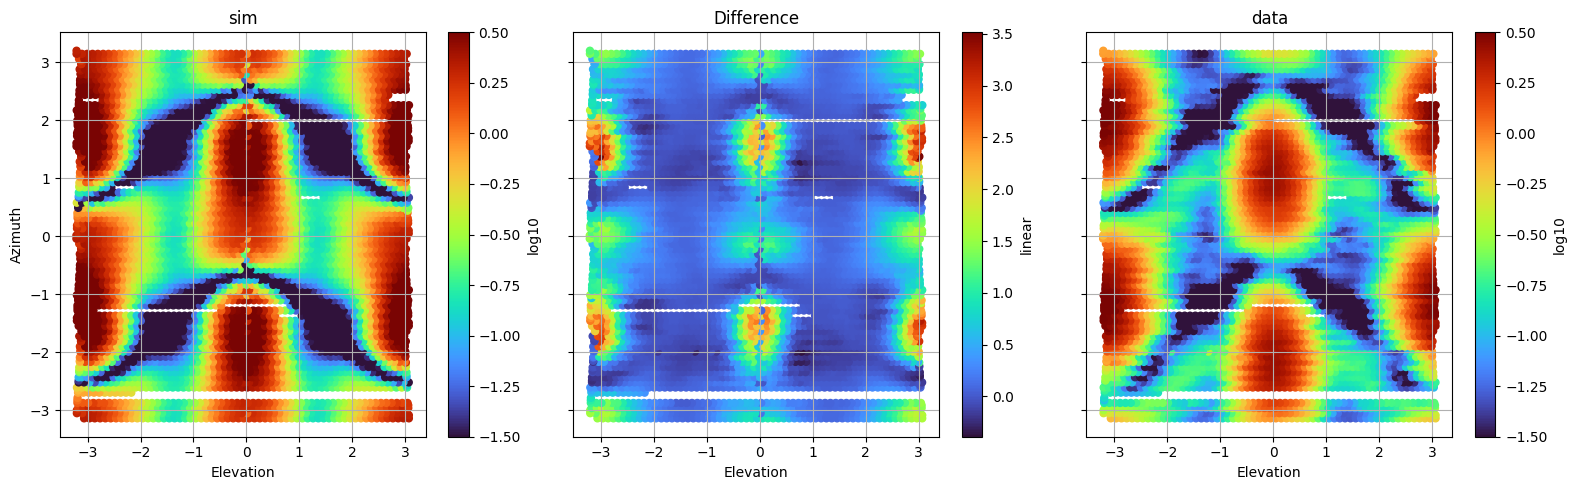

In [14]:
vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
rot_norm = rot * norm[:,ch]
# sim_data = P_pred * P_pred_norm
sim_data = sim_p_rot * sim_norm_rot
diff =(sim_data) - (rot_norm)
# diff = np.log10(sim_p_rot) - np.log10(rot)
# diff = sim_data - rot_norm
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(rot_norm), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()

In [15]:
used_pix = hit_pxs
# used_pix = unique_hits

In [129]:
# XXX trying stuff
# --- helpers to invert your bounded maps ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
#     # capacities
#     c_th, c_ph = U_th - L_th, U_ph - L_ph
#     # feasible extra-sum interval
#     u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
#     u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))

#     # target extra-sum and split implied by th0, ph0
#     u0 = th0 + ph0 - (L_th + L_ph)
#     # clip u0 into feasible range
#     u0 = jnp.clip(u0, u_min, u_max)

#     # split s0 from th0 = L_th + u0*s0
#     s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)

#     # feasible s-interval at this u0 (to honor individual uppers)
#     s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph) / (u0 + eps)), 0.0)
#     s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,  c_th      / (u0 + eps)), 1.0)
#     s0 = jnp.clip(s0, s_lo0, s_hi0)

#     # map u0, s0 to raw space that your constrain() uses
#     u_unit  = (u0 - u_min) / (u_max - u_min + eps)
#     s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0) / (s_hi0 - s_lo0 + eps), 0.5)
#     u_raw   = inv_sigmoid(u_unit)
#     mix_raw = inv_sigmoid(s_unit)

#     # angles (your model uses sin/cos(alpha); for your synthetic data alpha=0, delta=0)
#     alpha_raw = inv_sigmoid((alpha0 % (2*jnp.pi)) / (2*jnp.pi))
#     delta_raw = inv_sigmoid((delta0 % (2*jnp.pi)) / (2*jnp.pi))

#     return [alpha_raw, delta_raw, u_raw, mix_raw]
# XXX trying stuff
    
def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px

def fit_affine(y, m, eps=1e-8):
    y = y.ravel(); m = m.ravel()
    ym, mm = jnp.mean(y), jnp.mean(m)
    yc, mc = y - ym, m - mm
    a = jnp.vdot(yc, mc) / (jnp.vdot(mc, mc) + eps)
    b = ym - a * mm
    return a.real, b.real

# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(rot, m)
#     resid = rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(rot) + 1e-12)   # NRMSE^2
# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(sim_p_rot, m)
#     resid = sim_p_rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(sim_p_rot) + 1e-12)   # NRMSE^2


def model(params):
    alpha, delta, th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)
# XXX adding crazy stuff

# --- init raw params from your current px (same tuple structure everywhere) ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=jnp.min(m_th), U_th=jnp.max(m_th), L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),
                        Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi), eps=1e-8):
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    u0 = jnp.clip(th0 + ph0 - (L_th + L_ph), u_min, u_max)
    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)
    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)
    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    return (alpha_raw, delta_raw, u_raw, mix_raw)  # TUPLE, keep it a tuple.

# --- params & one optimizer (multi_transform) ---
# alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3
ph0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3

# L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi, pad=0.0)

# init raws from seeds using THESE bounds
# params = init_params_from_px(
#     alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
#     L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
# )

params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e0)),
    },
    # labels PyTree MUST match params structure:
    param_labels=("angles","angles","px","px"),
)
opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once

# --- px-only step (angles frozen), uses the SAME tx/opt_state ---
@jax.jit
def train_step_px_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def loss_ud(u, m):
        return loss_fnc((a_raw, d_raw, u, m))
    loss, (g_u, g_m) = jax.value_and_grad(loss_ud, argnums=(0,1))(u_raw, m_raw)
    grads = (jnp.zeros_like(a_raw), jnp.zeros_like(d_raw), g_u, g_m)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    # re-pin angles exactly:
    p = (a_raw, d_raw, p[2], p[3])
    return p, s, loss

# --- joint step (same tx) ---
@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# ---------- run ----------
# (optional) a few px-only warmup steps
for _ in range(2000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if _ % 100 ==0:
        print(loss)

# joint fine-tune
# for step in range(1000):
#     params, opt_state, loss = train_step_joint(params, opt_state)
#     if step % 100 == 0:
#         print(f"joint step {step:04d}  loss={float(loss):.6e}")

# alpha, delta, th_px, ph_px = params
# XXX adding crazy stuff


# @jax.jit
# def train_step(params, opt_state):
#     loss, grads = jax.value_and_grad(loss_fnc)(params)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, opt_state, loss


# alpha0 = 0.0
# delta0 = 0.0
# th0 = jnp.asarray(m_th[used_pix],  dtype=jnp.float64)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float64)

# params = init_params_from_px(alpha0, delta0, th0, ph0)  # <-- raw params consistent with constrain()
# optimizer = optax.adam(1e-3)  # suggest 1e-3 here; 1e-1 often too hot with sigmoids
# opt_state = optimizer.init(params)



# # learning_rate = 1e-1
# # optimizer = optax.adam(learning_rate)

# # alpha = 0.0
# # delta = 0.0
# # th_px = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# # ph_px = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
# # # th_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # # ph_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # params = [alpha, delta, th_px, ph_px]
# # opt_state = optimizer.init(params)

# for epoch in range(10000):
#     params, opt_state, loss = train_step(params, opt_state)
#     if epoch % 1000 == 0:
#         print(f"epoch {epoch:02d}  loss={loss:.6f}")
        

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

2.573249561918575
0.18221636167316949
0.1618345550479783
0.16331489363416896
0.16190649762999162
0.16052437413784287
0.16000575373919534
0.16630205117099484
0.16427703797942075
0.16751848053047383
0.1673331216271002
0.16344762150885508
0.16313588988601668
0.16294211715422086
0.16281636542269026
0.1629480145740147
0.16281028389799793
0.16311273866116185
0.16221566193432796
0.16229405197705754
6.283184e-06 6.283184e-06


In [455]:
@jax.jit
def step_angles_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def L(a, d): return loss_fnc((a, d, u_raw, m_raw))
    loss, (ga, gd) = jax.value_and_grad(L, argnums=(0,1))(a_raw, d_raw)
    grads = (ga, gd, jnp.zeros_like(u_raw), jnp.zeros_like(m_raw))
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss
# Pixels-only step you already have (train_step_px_only)
# Joint step you already have (train_step_joint)

# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
# alpha0 = jnp.array(0.0, dtype=jnp.float32)
alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
delta0 = jnp.array(jnp.pi/6, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.ones_like(used_pix, dtype=jnp.float32)
ph0 = jnp.ones_like(used_pix, dtype=jnp.float32)

L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi)

# init raws from seeds using THESE bounds
params = init_params_from_px(
    alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
    L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
)

# params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
  {
    "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(2e-3)),  # ↑
    "px":     optax.chain(optax.clip_by_global_norm(0.5),
                          optax.adam(8e-4),
                          optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, decay_steps=800))),
  },
  param_labels=("angles","angles","px","px"),
)

opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once
# Schedule per frequency:
for _ in range(50):   # let angles actually move
    params, opt_state, _ = step_angles_only(params, opt_state)
for _ in range(150):  # pixels catch up (your px-only step)
    params, opt_state, _ = train_step_px_only(params, opt_state)
for _ in range(400):  # joint fine-tune
    params, opt_state, _ = train_step_joint(params, opt_state)

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

KeyboardInterrupt: 

In [414]:
loss, g = jax.value_and_grad(loss_fnc)(params)
print("‖∇alpha‖", float(jnp.linalg.norm(g[0])), "‖∇delta‖", float(jnp.linalg.norm(g[1])))
print("‖∇u_raw‖", float(jnp.linalg.norm(g[2])), "‖∇mix_raw‖", float(jnp.linalg.norm(g[3])))


‖∇alpha‖ 0.07350975275039673 ‖∇delta‖ 0.01014619879424572
‖∇u_raw‖ 0.0015800291439518332 ‖∇mix_raw‖ 0.002537030028179288


In [248]:
import jax, jax.numpy as jnp, jax.nn as jnn
import optax

# ---------- helpers ----------
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=1e-8, U_th=4.0,
                        L_ph=1e-9, U_ph=4.1,
                        Smin=0.027, Smax=4.25, eps=1e-8):
    # capacities & feasible u-range
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))

    u0 = th0 + ph0 - (L_th + L_ph)
    u0 = jnp.clip(u0, u_min, u_max)

    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)

    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)

    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    # IMPORTANT: return a TUPLE, and keep it a tuple forever
    return (alpha_raw, delta_raw, u_raw, mix_raw)

# ---------- init (use your current maps for a clean synthetic test) ----------
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)

params = init_params_from_px(alpha0, delta0, th0, ph0)   # tuple!
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

# ---------- px-only training step (angles frozen), preserving the same PyTree ----------
@jax.jit
def train_step_px_only(params, opt_state):
    alpha_raw_f, delta_raw_f, u_raw, mix_raw = params

    def loss_with_frozen_angles(u_raw_, mix_raw_):
        p = (alpha_raw_f, delta_raw_f, u_raw_, mix_raw_)  # keep angles fixed in-graph
        return loss_fnc(p)

    # get grads w.r.t (u_raw, mix_raw) only
    loss, (g_u, g_m) = jax.value_and_grad(loss_with_frozen_angles, argnums=(0,1))(u_raw, mix_raw)

    # assemble a grads tuple matching params' structure: zeros for angles
    g0 = jnp.zeros_like(alpha_raw_f); g1 = jnp.zeros_like(delta_raw_f)
    grads = (g0, g1, g_u, g_m)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    # keep angles exactly frozen (in case optimizer adds tiny noise)
    params = (alpha_raw_f, delta_raw_f, params[2], params[3])
    return params, opt_state, loss

# ---------- run px-only optimization ----------
for step in range(1000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if step % 100 == 0:
        print(f"px-only step {step:04d}  loss={float(loss):.6e}")

# get constrained pixels and compare to your synthetic truth
alpha_c, delta_c, th_hat, ph_hat = constrain(params)
print("th MSE:", float(jnp.mean((th_hat - th0)**2)),
      "ph MSE:", float(jnp.mean((ph_hat - ph0)**2)))


px-only step 0000  loss=3.132061e-10
px-only step 0100  loss=1.587241e-12
px-only step 0200  loss=1.888117e-13
px-only step 0300  loss=1.422311e-13
px-only step 0400  loss=1.516761e-13
px-only step 0500  loss=2.166829e-13
px-only step 0600  loss=2.061246e-13
px-only step 0700  loss=3.276818e-12
px-only step 0800  loss=9.677779e-13
px-only step 0900  loss=5.230506e-13
th MSE: 2.6432578348334346e-10 ph MSE: 6.720930478820719e-10


In [249]:

# group-specific optax
tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-3)),
    },
    param_labels=("angles","angles","px","px"),  # matches (alpha, delta, u_raw, mix_raw)
)

opt_state = tx.init(params)  # params = tuple from your px-only success

@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# optional: a few more px-only steps (small number) to stabilize
for _ in range(200):  # you already did 1000; this is just a touch-up
    params, opt_state, _ = train_step_joint(params, opt_state)  # fine if you skip—px are already good

# joint fine-tune
for step in range(1000):
    params, opt_state, loss = train_step_joint(params, opt_state)
    if step % 100 == 0:
        print(f"joint step {step:04d}  loss={float(loss):.6e}")


joint step 0000  loss=1.052107e-13
joint step 0100  loss=8.728632e-14
joint step 0200  loss=9.410802e-14
joint step 0300  loss=1.491335e-13
joint step 0400  loss=1.232313e-13
joint step 0500  loss=2.326523e-13
joint step 0600  loss=1.112922e-12
joint step 0700  loss=2.505823e-10
joint step 0800  loss=6.382329e-11
joint step 0900  loss=1.149144e-10


In [250]:
alpha_c, delta_c, th_hat, ph_hat = constrain(params)
print("alpha(rad)=", float(alpha_c), "delta(rad)=", float(delta_c))
print("px ranges: th[%.3g, %.3g] ph[%.3g, %.3g]" %
      (float(th_hat.min()), float(th_hat.max()),
       float(ph_hat.min()), float(ph_hat.max())))


alpha(rad)= 6.283291895670118e-06 delta(rad)= 6.283184120547958e-06
px ranges: th[2.63e-07, 3.98] ph[2.26e-07, 4.05]


0.23715938602944642


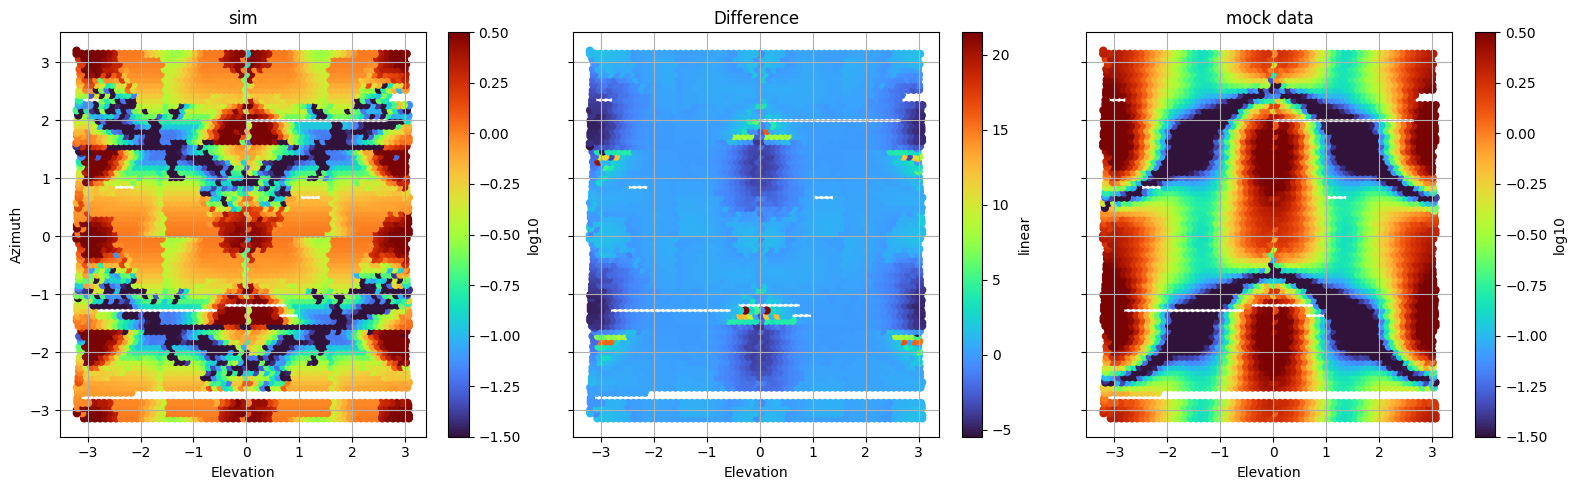

In [184]:
sim_p = model(params)
sim_norm = 1/jnp.mean(sim_p, axis=None)

# data_comp = rot
data_comp = sim_p_rot

vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
# data_comp_norm = data_comp * norm[:,ch]
data_comp_norm = data_comp * sim_norm_rot
sim_data = sim_p * sim_norm # - .5+0.08329490672191896
diff = (sim_data) - (data_comp_norm)
print(jnp.median(diff))
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=-0.02, vmax=0.02)#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(data_comp_norm), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('mock data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()

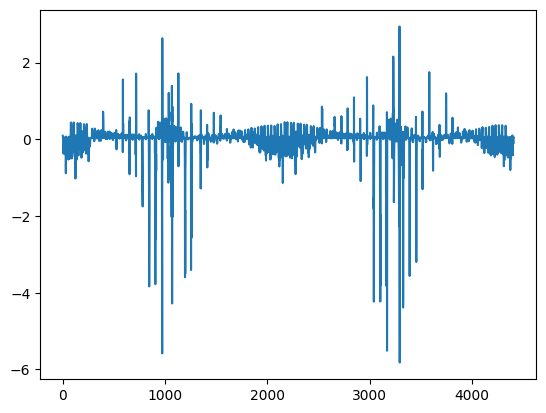

In [131]:
plt.figure()
plt.plot(diff)
plt.show()

-8.881784197001252e-16
0.0007872800796472033


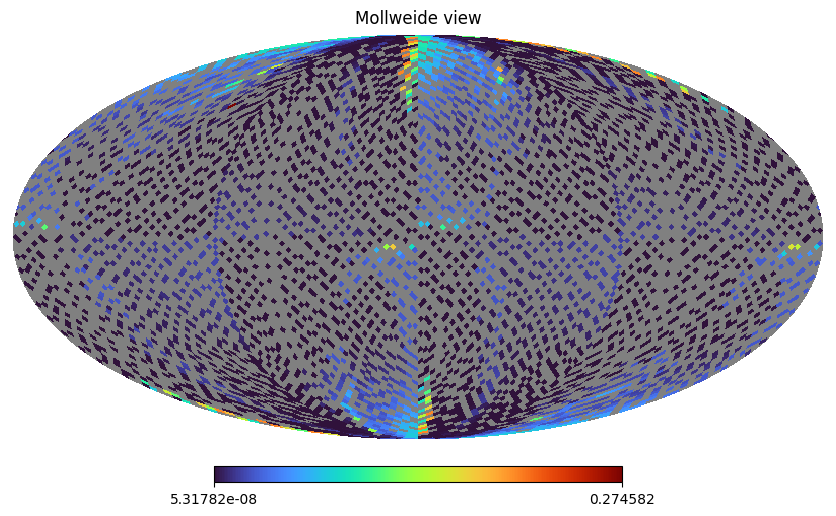

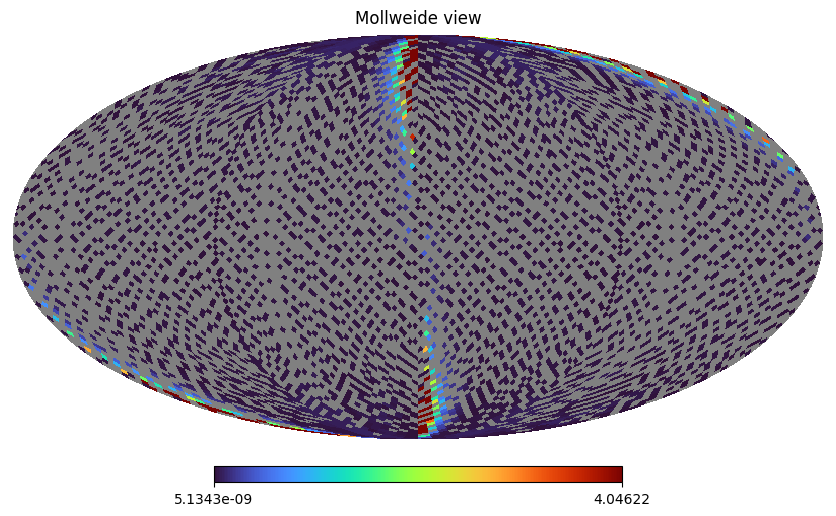

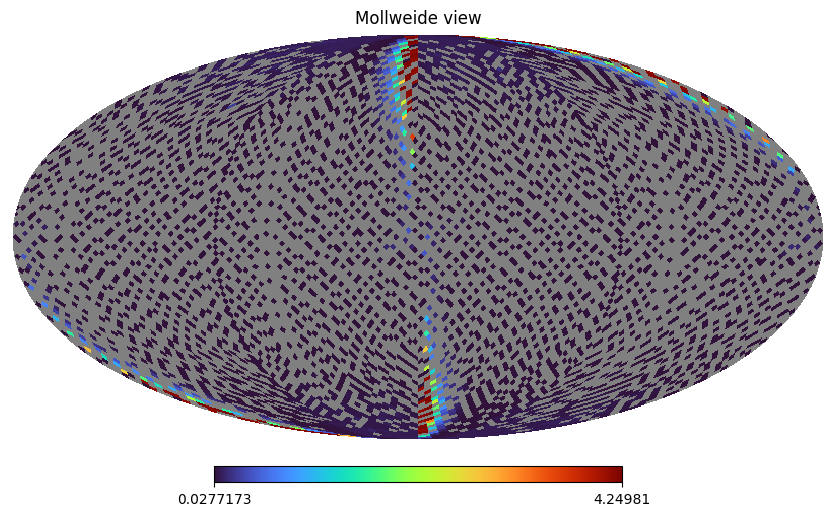

In [132]:
fit_th = jnp.full_like(m_th, healpy.UNSEEN)
fit_ph = jnp.full_like(m_phi, healpy.UNSEEN)
fit_total = jnp.full_like(m_phi, healpy.UNSEEN)
# fit_th = fit_th.at[unique_hits].set(th_px)
# fit_ph = fit_ph.at[unique_hits].set(ph_px)
fit_th = fit_th.at[used_pix].set(th_px)
fit_ph = fit_ph.at[used_pix].set(ph_px)
fit_total = fit_total.at[used_pix].set(fit_ph[used_pix] + fit_th[used_pix])
print(jnp.max(m_th[used_pix] + m_phi[used_pix]) - jnp.max(fit_total[used_pix]))
print(jnp.min(m_th[used_pix] + m_phi[used_pix]) - jnp.min(fit_total[used_pix]))

healpy.mollview(fit_th   , rot=(0, 0, 0), cmap='turbo')
healpy.mollview(fit_ph   , rot=(0, 0, 0), cmap='turbo')
healpy.mollview(fit_total, rot=(0, 0, 0), cmap='turbo')
# healpy.mollview( m_th)
# healpy.mollview(m_phi)

<Figure size 640x480 with 0 Axes>

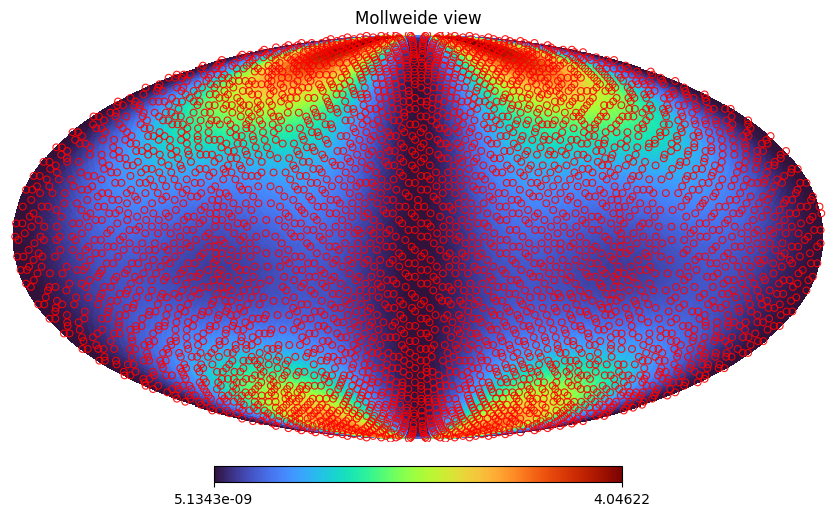

In [173]:
nest = False
plt.figure()
healpy.mollview(m_phi, nest=nest, cmap="turbo")
pix   = np.asarray(used_pix, dtype=np.int64)
upix, counts = np.unique(pix, return_counts=True)
theta, phi   = healpy.pix2ang(DEFAULT_NSIDE, upix, nest=nest)     # radians
# lon          = np.degrees(phi)                        # [0, 360)
# lat          = 90.0 - np.degrees(theta)               # [-90, 90]
lon, lat = healpy.pix2ang(DEFAULT_NSIDE, upix, nest=nest, lonlat=True)

sizes = 24  # e.g., 10 + 40*np.sqrt(counts / counts.max())
healpy.projscatter(
    lon, lat, lonlat=True,
    s=sizes, marker="o",
    facecolors="none", edgecolors="red", linewidths=0.8, alpha=0.9)

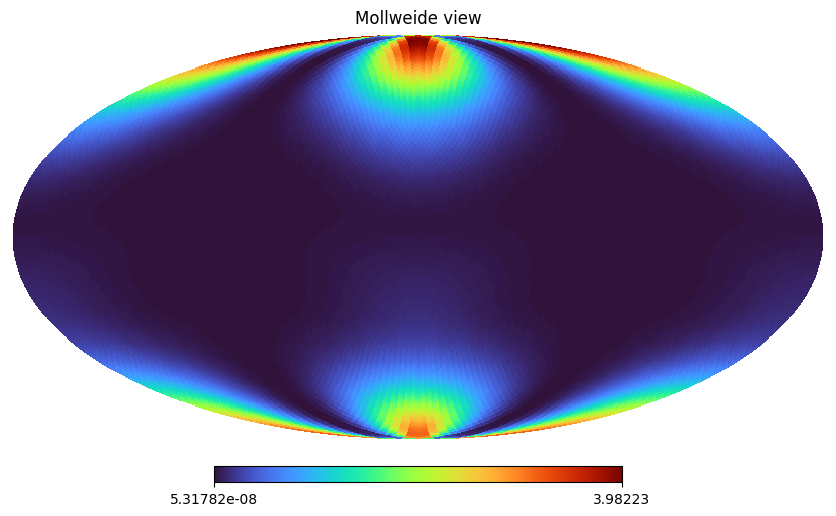

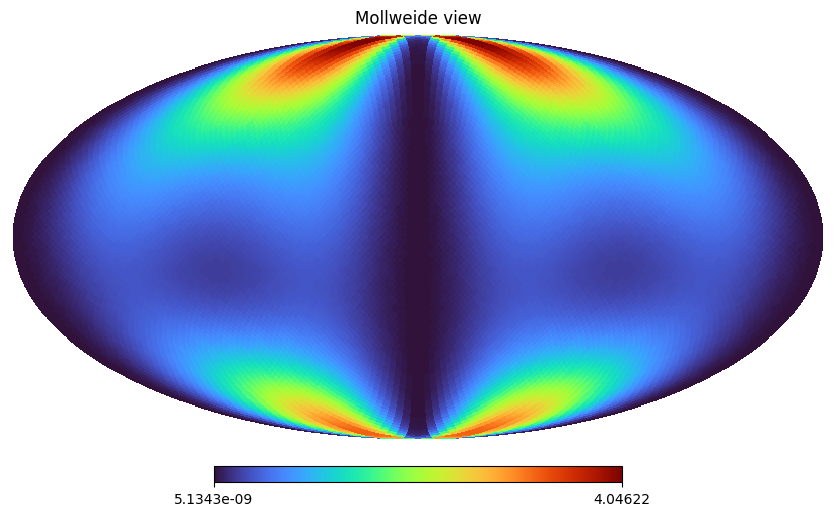

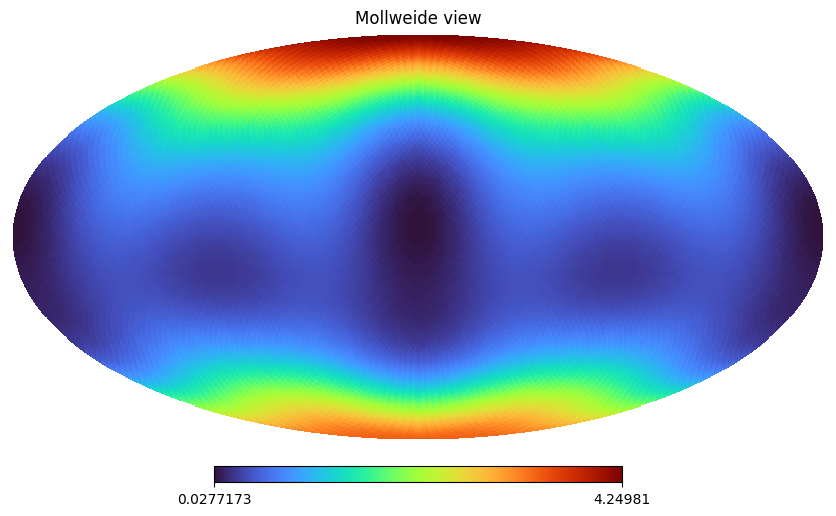

In [22]:

healpy.mollview( m_th, cmap='turbo')
healpy.mollview(m_phi, cmap='turbo')
healpy.mollview(m_phi+m_th, cmap='turbo')

In [16]:
scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)
print(scale_factor)

0.9545767459638989


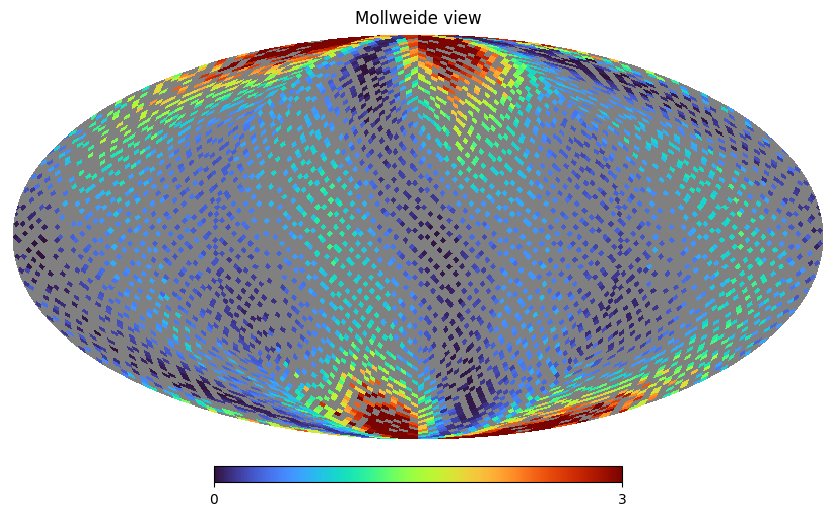

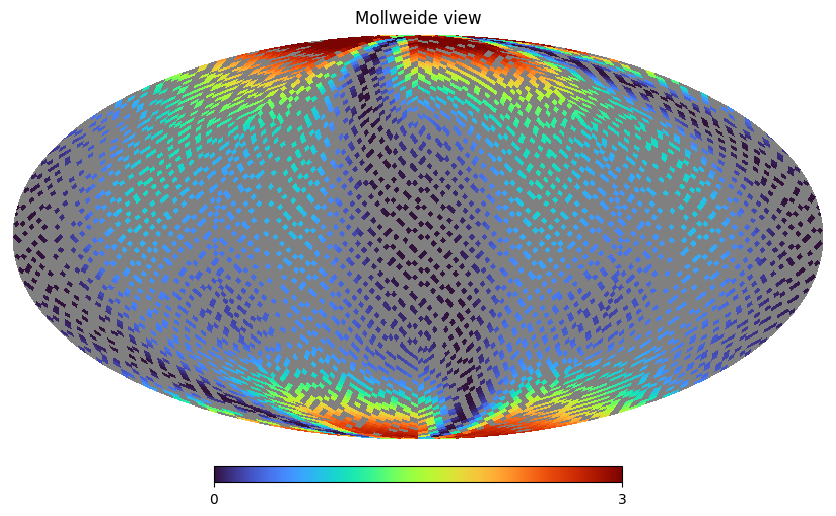

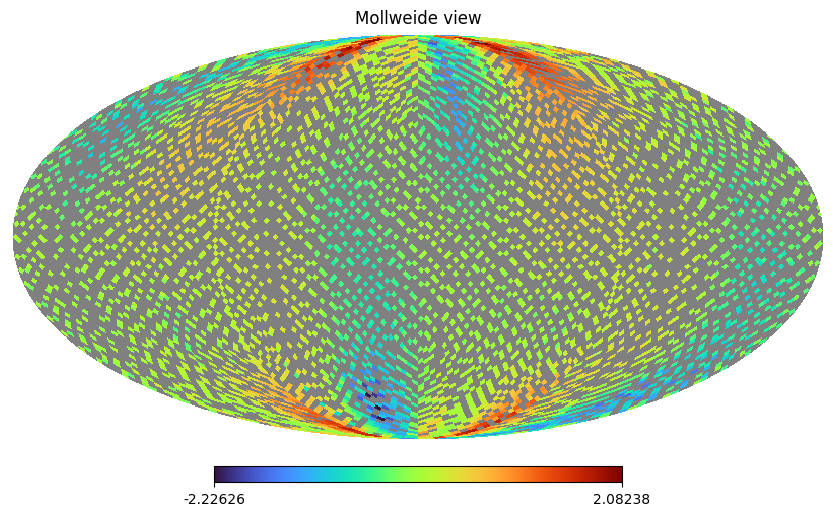

In [17]:
def beam_proj(px, pwr, vmin=0, vmax=3):
    m = jnp.full_like(m_th, healpy.UNSEEN)
    m = m.at[px].set(pwr)
    healpy.mollview(m, cmap='turbo', min=vmin, max=vmax)

beam_proj(hit_pxs, rot*norm[:,ch])
beam_proj(hit_pxs, scale_factor * sim_data)
beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

In [16]:
alpha_angle = jnp.linspace(0, 360, 1024, endpoint=False)# * -1

In [20]:
# txe1 = 0.0#.3 # .4
# txe2 = 1.0#.7 # .6 looks close actually, when plotted over time
# txe1 = 0.7#.3 # .4
# txe2 = 0.3#.7 # .6 looks close actually, when plotted over time
# ones_th = jnp.zeros_like(m_th) * 10  
# ones_ph = jnp.zeros_like(m_phi)* 10
# ones_th = ones_th.at[hit_pxs].set(1)
# ones_ph = ones_ph.at[hit_pxs].set(1)
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
# rx_true = RotatingAntenna(beam_th=ones_th, beam_phi=ones_ph)
el_correction = -jnp.deg2rad(0.0)
az_correction = jnp.deg2rad(0)

az_inds = np.deg2rad(fitter.az_deg[fitter.inds]) + az_correction#+ np.pi
el_inds = np.deg2rad(fitter.el_deg[fitter.inds]) + el_correction


rx_true._theta_flip_to_data = False   # <- enable the convention used by your (az, el) scatter

coord = jnp.array([-0.0, 0.0, -1])
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-30)

# sim_p, hit_pxs = simulate_powers_vmap(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2)
# sim_p, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(180), K=0.2730307444904443, C0=0.5957045841041818)
# sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
# sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)

ress = jnp.zeros_like(alpha_angle)

for i,j in enumerate(alpha_angle):
    txe1 = jnp.sin(jnp.deg2rad(j))**2
    txe2 = jnp.cos(jnp.deg2rad(j))**2
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
    sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
    sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
    sim_data = sim_p_rot * sim_norm_rot
    scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)
    res = jnp.mean((scale_factor*sim_data - rot*norm[:,ch])**2)
    ress = ress.at[i].add(res)

ress.shape

(1024,)

In [451]:
jnp.where(ress == jnp.amin(ress))
ress[jnp.isclose(ress, jnp.min(ress))][0]

Array(0.26431317, dtype=float64)

16.875


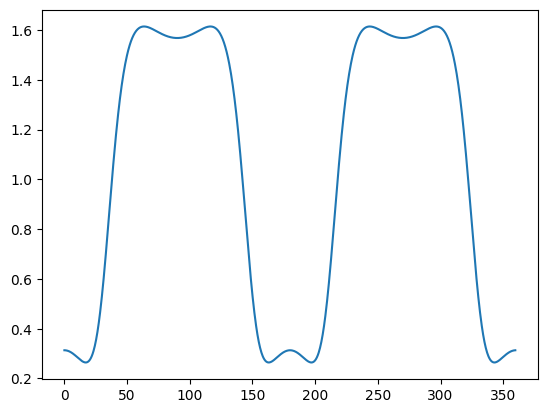

In [21]:
# print(alpha_angle[jnp.argmin(ress)])
print(alpha_angle[jnp.isclose(ress, jnp.min(ress))][0])#jnp.argmin(ress)])
plt.figure()
plt.plot(alpha_angle, ress)
# plt.plot(ress)
# plt.axvline(16.875)
plt.show()

343.125


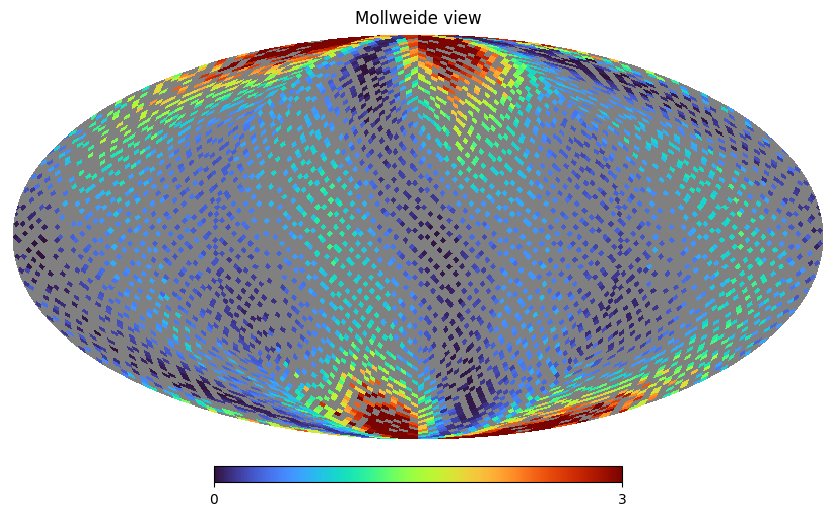

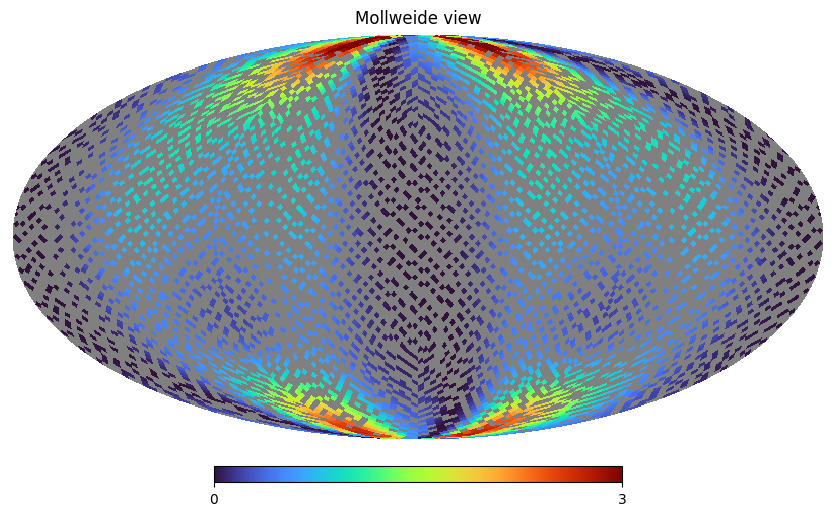

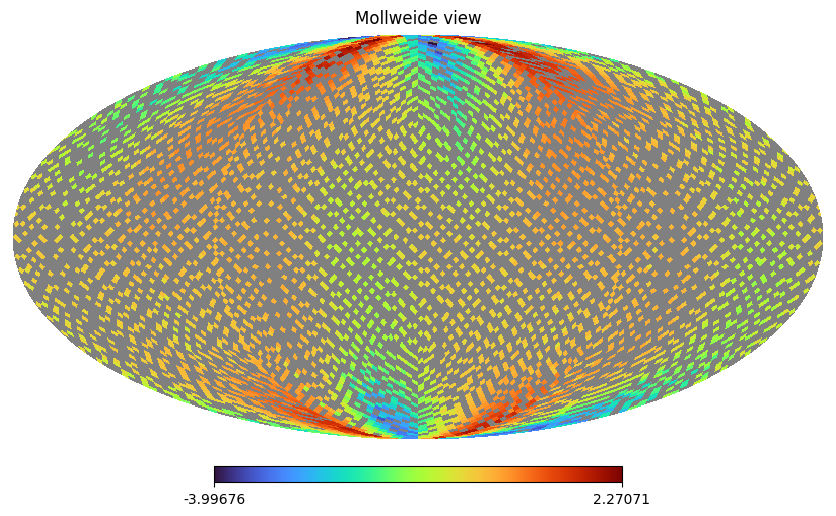

In [25]:
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
txe1 = jnp.sin(alpha_angle[jnp.argmin(ress)])**2
txe2 = jnp.cos(alpha_angle[jnp.argmin(ress)])**2
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)

sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)
sim_data = sim_p_rot * sim_norm_rot
scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)

print(alpha_angle[jnp.argmin(ress)])

beam_proj(hit_pxs, rot*norm[:,ch])
beam_proj(hit_pxs, scale_factor * sim_data)
beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

In [17]:


best_alphas = jnp.zeros(51)
for chan in range(best_alphas.shape[0] - 1):
    ress = jnp.zeros_like(alpha_angle)
    rot = reduced[:, chan+13][sl][val][fitter.inds] #* norm[:, ch]
    m_th = beam_maps_th[chan]
    m_phi = beam_maps_ph[chan]
    rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
    for i,j in enumerate(alpha_angle):
        txe1 = jnp.sin(jnp.deg2rad(j))**2
        txe2 = jnp.cos(jnp.deg2rad(j))**2
        tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
        sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
        sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
        sim_data = sim_p_rot * sim_norm_rot
        scale_factor = jnp.sum(rot*norm[:, chan+13] * sim_data) / jnp.sum(sim_data**2)
        res = jnp.mean((scale_factor*sim_data - rot*norm[:,chan+13])**2)
        ress = ress.at[i].set(res)
    first_angle = alpha_angle[jnp.isclose(ress, jnp.min(ress))][0]
# ress[jnp.isclose(ress, jnp.min(ress))][0]
    best_alphas = best_alphas.at[chan].set(first_angle)
    print(chan)

best_alphas.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(51,)

In [325]:
beam_maps_th.shape[0], chs.shape, best_alphas.shape

(52, (63,), (51,))

In [278]:
# reduced[:, 63]
freqs[chs].shape

(63,)

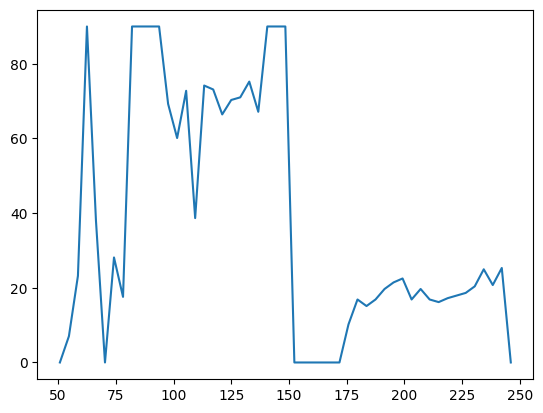

In [38]:
plt.figure()
plt.plot(freqs[::16][13:], best_alphas)
# plt.plot(best_alphas)
# plt.axhline(25)
plt.show()

148.4375 90.0


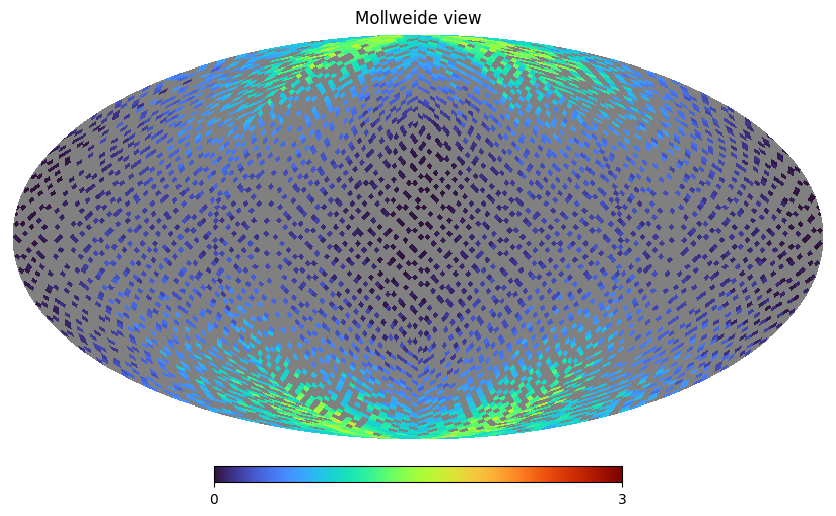

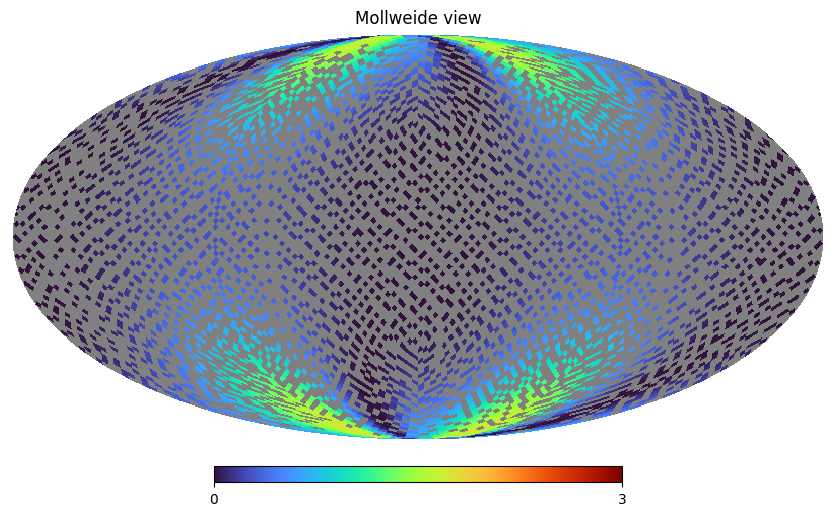

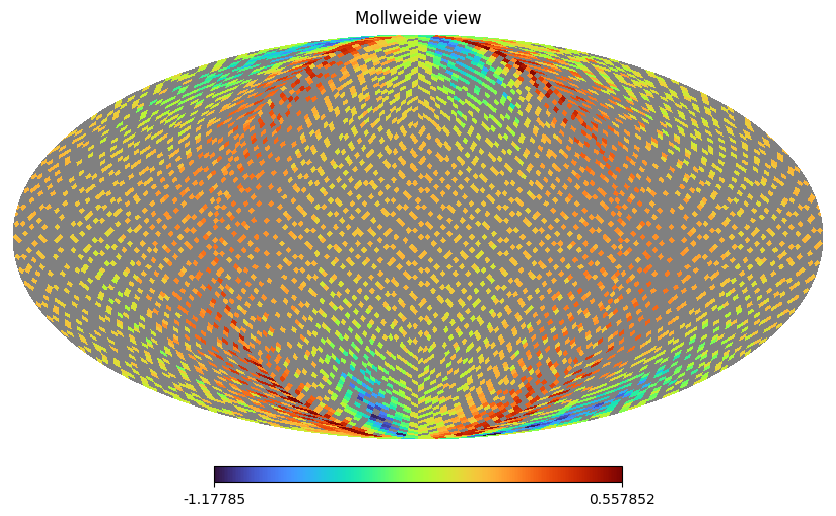

In [43]:
test_ch = 37
rot = reduced[:, test_ch][sl][val][fitter.inds] #* norm[:, ch]
m_th = beam_maps_th[test_ch-13]
m_phi = beam_maps_ph[test_ch-13]
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
txe1 = jnp.sin(jnp.deg2rad(best_alphas[test_ch-13]))**2
txe2 = jnp.cos(jnp.deg2rad(best_alphas[test_ch-13]))**2
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)

sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
sim_data = sim_p_rot * sim_norm_rot
scale_factor = jnp.sum(rot*norm[:, test_ch] * sim_data) / jnp.sum(sim_data**2)
print(freqs[chs][test_ch], best_alphas[test_ch-13])
beam_proj(hit_pxs, rot*norm[:,test_ch])
beam_proj(hit_pxs, scale_factor * sim_data)
beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,test_ch], vmin=None, vmax=None)

In [129]:
# XXX trying stuff
# --- helpers to invert your bounded maps ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

    
def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px

def fit_affine(y, m, eps=1e-8):
    y = y.ravel(); m = m.ravel()
    ym, mm = jnp.mean(y), jnp.mean(m)
    yc, mc = y - ym, m - mm
    a = jnp.vdot(yc, mc) / (jnp.vdot(mc, mc) + eps)
    b = ym - a * mm
    return a.real, b.real

# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(rot, m)
#     resid = rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(rot) + 1e-12)   # NRMSE^2
# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(sim_p_rot, m)
#     resid = sim_p_rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(sim_p_rot) + 1e-12)   # NRMSE^2


def model(params, alpha, delta):
    th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)
# XXX adding crazy stuff

# --- init raw params from your current px (same tuple structure everywhere) ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=jnp.min(m_th), U_th=jnp.max(m_th), L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),
                        Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi), eps=1e-8):
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    u0 = jnp.clip(th0 + ph0 - (L_th + L_ph), u_min, u_max)
    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)
    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)
    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    return (alpha_raw, delta_raw, u_raw, mix_raw)  # TUPLE, keep it a tuple.

# --- params & one optimizer (multi_transform) ---
# alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3
ph0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3

# L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi, pad=0.0)

# init raws from seeds using THESE bounds
# params = init_params_from_px(
#     alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
#     L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
# )

params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e0)),
    },
    # labels PyTree MUST match params structure:
    param_labels=("angles","angles","px","px"),
)
opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once

# --- px-only step (angles frozen), uses the SAME tx/opt_state ---
@jax.jit
def train_step_px_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def loss_ud(u, m):
        return loss_fnc((a_raw, d_raw, u, m))
    loss, (g_u, g_m) = jax.value_and_grad(loss_ud, argnums=(0,1))(u_raw, m_raw)
    grads = (jnp.zeros_like(a_raw), jnp.zeros_like(d_raw), g_u, g_m)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    # re-pin angles exactly:
    p = (a_raw, d_raw, p[2], p[3])
    return p, s, loss

# --- joint step (same tx) ---
@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# ---------- run ----------
# (optional) a few px-only warmup steps
for _ in range(2000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if _ % 100 ==0:
        print(loss)

# joint fine-tune
# for step in range(1000):
#     params, opt_state, loss = train_step_joint(params, opt_state)
#     if step % 100 == 0:
#         print(f"joint step {step:04d}  loss={float(loss):.6e}")

# alpha, delta, th_px, ph_px = params
# XXX adding crazy stuff


# @jax.jit
# def train_step(params, opt_state):
#     loss, grads = jax.value_and_grad(loss_fnc)(params)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, opt_state, loss


# alpha0 = 0.0
# delta0 = 0.0
# th0 = jnp.asarray(m_th[used_pix],  dtype=jnp.float64)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float64)

# params = init_params_from_px(alpha0, delta0, th0, ph0)  # <-- raw params consistent with constrain()
# optimizer = optax.adam(1e-3)  # suggest 1e-3 here; 1e-1 often too hot with sigmoids
# opt_state = optimizer.init(params)



# # learning_rate = 1e-1
# # optimizer = optax.adam(learning_rate)

# # alpha = 0.0
# # delta = 0.0
# # th_px = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# # ph_px = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
# # # th_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # # ph_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # params = [alpha, delta, th_px, ph_px]
# # opt_state = optimizer.init(params)

# for epoch in range(10000):
#     params, opt_state, loss = train_step(params, opt_state)
#     if epoch % 1000 == 0:
#         print(f"epoch {epoch:02d}  loss={loss:.6f}")
        

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

2.573249561918575
0.18221636167316949
0.1618345550479783
0.16331489363416896
0.16190649762999162
0.16052437413784287
0.16000575373919534
0.16630205117099484
0.16427703797942075
0.16751848053047383
0.1673331216271002
0.16344762150885508
0.16313588988601668
0.16294211715422086
0.16281636542269026
0.1629480145740147
0.16281028389799793
0.16311273866116185
0.16221566193432796
0.16229405197705754
6.283184e-06 6.283184e-06


In [ ]:
def model(params, alpha, delta):
    th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)

def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px


In [396]:
best_alphas.shape

(51,)